# On-line Portfolio Selection Testing
### Imports

In [1]:
# IMPORTS
import os
import numpy as np
from utils.data import read_stock_history, normalize
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns
from model.benchmarks_olps import tools, algos
from model.benchmarks_olps.algos import *
from model.benchmarks_olps.result import AlgoResult, ListResult
from environment.portfolio import PortfolioEnv, MultiActionPortfolioEnv
from stock_trading import test_portfolio_selection, test_portfolio_selection_multiple, plot_weights, plot_portfolio_values, results_table, test_with_given_weights

print("Imports Complete!")







Imports Complete!


### Variables and configuration

In [2]:
window_length = 3

In [3]:
# Dataset
history, abbreviation, date_list = read_stock_history(filepath='utils/datasets/Hegde.h5')
print("Dataset Shape: {}".format(history.shape))
print("Dataset Dates: {} -> {}".format(date_list[0], date_list[-1]))

Dataset Shape: (20, 3778, 4)
Dataset Dates: 31/12/2001 -> 30/12/2016


In [4]:
# Get Close
_history = history[:, :, :4]
# Target Stocks
target_stocks = abbreviation
# Target History
target_history = np.empty(shape=(len(target_stocks), _history.shape[1], _history.shape[2]))
for i, stock in enumerate(target_stocks):
    target_history[i] = _history[abbreviation.index(stock), :, :]

print("Assets: ", target_stocks)
print("Target History Sample: ", target_history[0][0])
print("Target History Shape: ", target_history.shape)

Assets:  ['CSX', 'DISH', 'EA', 'EBAY', 'HAS', 'ILMN', 'MAR', 'REGN', 'SBUX', 'FISV', 'ESRX', 'DLTR', 'CTSH', 'CSCO', 'BKNG', 'AMGN', 'WDC', 'NVDA', 'MSFT', 'FOX']
Target History Sample:  [5.81166697 5.9000001  5.80666685 5.84166718]
Target History Shape:  (20, 3778, 4)


### Environment setup

In [5]:
# Training/Testing Date Range
full_length = len(date_list)
train_test_ratio = 6/7
train_start_date = date_list[window_length]
train_end_date = date_list[(int)(full_length * train_test_ratio)-1]
test_start_date = date_list[(int)(full_length * train_test_ratio)]
test_end_date = date_list[full_length-2]
print("Full Date Range: {} -> {} ({} Steps)".format(train_start_date, test_end_date, 
                                                    (int)(date_list.index(test_end_date) - date_list.index(train_start_date))))

Full Date Range: 04/01/2002 -> 29/12/2016 (3773 Steps)


In [6]:
# Set Up Environment
env = PortfolioEnv(target_history, target_stocks, date_list, trading_cost=0, start_date=train_start_date, 
                              end_date=test_end_date, window_length=window_length, olps=True)

/home/nigel/anaconda3/envs/tensor_keras_portfolio/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


### Test Portfolio Selection

In [7]:
models = ['CRP', 'BCRP']#, 'OLMAR'#, 'PAMR', 'RMR', 'WMAMR', 'EG', 'ONS', 'UP']
observations_list, portfolio_values_list, weights_list, dates = test_portfolio_selection_multiple(env, models)

=========CRP=========
len(weights_array): 3778
=========BCRP=========
252.0
len(weights_array): 3774


In [8]:
len(env.close_df)

3778

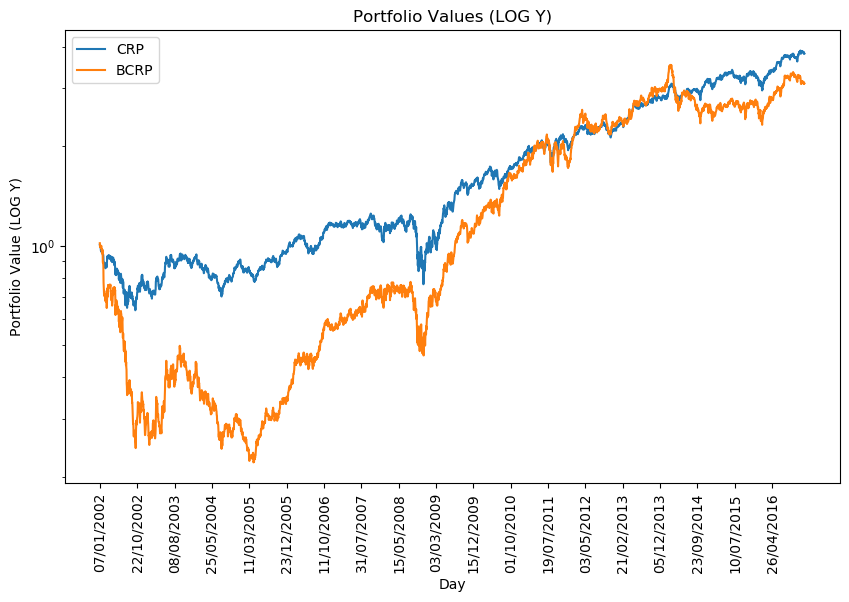

In [9]:
plot_portfolio_values(models, portfolio_values_list, dates)

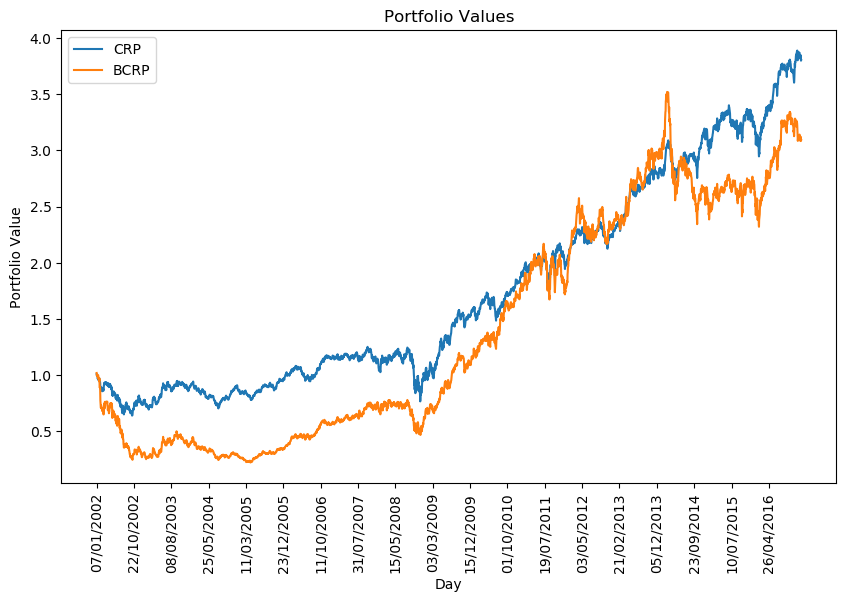

In [10]:
plot_portfolio_values(models, portfolio_values_list, dates, log_y=False)

In [11]:
results_table(models, portfolio_values_list)

,Portfolio,Average Daily Yield (%),Sharpe Ratio (%),Sortino Ratio (%),Maximum Drawdown (%),Final Portfolio Value
0,CRP,0.0422,3.5785,4.9566,38.8467,3.806
1,BCRP,0.0472,2.5074,3.6089,78.2584,3.093


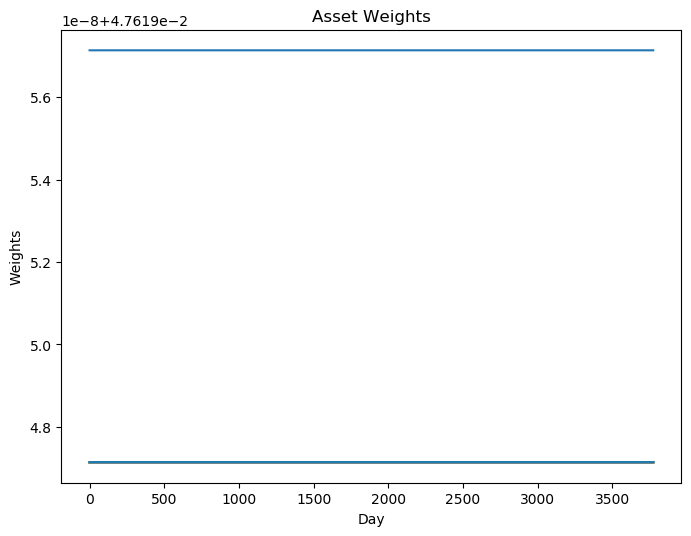

In [12]:
plot_weights(weights_list[0])

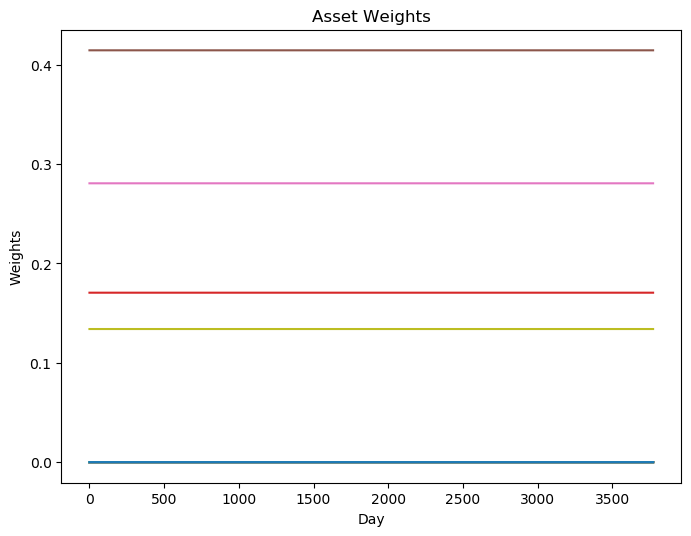

In [13]:
plot_weights(weights_list[1])

In [14]:
_, _, olps_portfolio_values, _, _ = test_with_given_weights(env, weights_list[1])

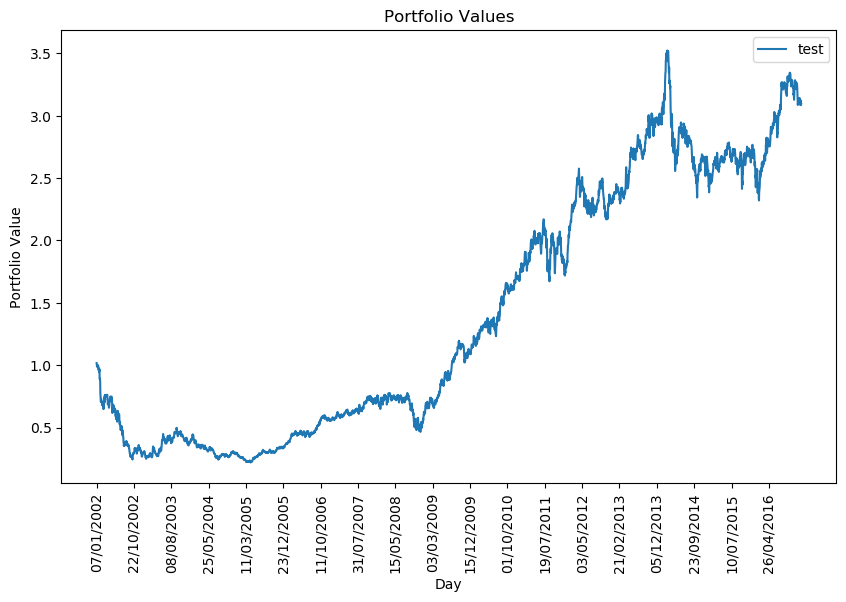

In [15]:
plot_portfolio_values(['test'], [olps_portfolio_values], dates, log_y=False)

In [16]:
_, _, olps_portfolio_values, _, _ = test_with_given_weights(env, weights_list[0])

In [17]:
plot_portfolio_values(['test'], [olps_portfolio_values], dates, log_y=False)

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7fd98b1fbb00> (for post_execute):


KeyboardInterrupt: 

In [ ]:
X = env.close_df_subset
X.head()

In [ ]:
objective = lambda b: -np.sum(np.log(np.maximum(np.dot(X - 1, b) + 1, 0.0001)))

In [ ]:
max_leverage = 1
x_0 = max_leverage * np.ones(X.shape[1]) / float(X.shape[1])

cons = ({'type': 'ineq', 'fun': lambda b: max_leverage - sum(b)},)

In [ ]:

import scipy.optimize as optimize
res = optimize.minimize(objective, x_0, bounds=[(0., max_leverage)]*len(x_0), constraints=cons, method='BFGS')

In [ ]:
res

In [ ]:
EPS = 1E-7
if (res.x < 0. - EPS).any() or (res.x > max_leverage + EPS).any():
    X = X + np.random.randn(1)[0] * 1E-5
    logging.debug('Optimal weights not found, trying again...')
    
elif res.success:
    print("Success")
else:
    if np.isnan(res.x).any():
        logging.warning('Solution does not exist, use zero weights.')
        res.x = np.zeros(X.shape[1])
    else:
        logging.warning('Converged, but not successfully.')
    


In [ ]:
_w = np.repeat([res.x], X.shape[0], axis=0)

In [ ]:
_, _, olps_portfolio_values, _, _ = test_with_given_weights(env, _w)

In [ ]:
plot_portfolio_values(['test'], [olps_portfolio_values], dates, log_y=False)